In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
import random

# For preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split 

# For LSTM model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback

# For FOPDT model
from scipy.integrate import odeint

# For hyperopt (parameter optimization)
# ! pip install hyperopt
from hyperopt import Trials, STATUS_OK, tpe, fmin, hp

In [2]:
# Define functions to generate FOPDT model data
def fopdt(y,t,um,Km,taum):
    # arguments
    #  y      = output
    #  t      = time
    #  uf     = input linear function (for time shift)
    #  Km     = model gain
    #  taum   = model time constant
    # calculate derivative
    dydt = (-(y-yp0) + Km * (um-u0))/taum
    return dydt

# simulate simple model with x=[Km,taum]
def sim_model(Km,taum):
    # array for model values
    ym = np.zeros(ns)
    # initial condition
    ym[0] = yp0
    # loop through time steps    
    for i in range(0,ns-1):
        ts = [t[i],t[i+1]]
        y1 = odeint(fopdt,ym[i],ts,args=(u[i],Km,taum))
        ym[i+1] = y1[-1]
    return ym

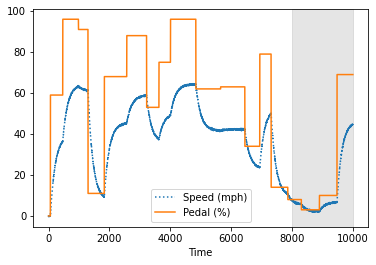

In [3]:
# Parameters and time for FOPDT model
ns = 10000
t = np.linspace(0,ns-1,ns)
u = np.zeros(ns)

# Additional FOPDT parameters
yp0 = 0.0
u0 = u[0]
Km = 0.67
taum = 160.0

# Generate step data for u
end = 60 # leave 1st minute of u as 0
while end <= ns:
    start = end
    end += random.randint(300,900) # keep new Q1s value for anywhere from 5 to 15 minutes
    u[start:end] = random.randint(0,100)

# Simulate FOPDT model
y = sim_model(Km,taum)

# Add Gaussian noise
noise = np.random.normal(0,0.2,ns)
y += noise

# Scale data
data = np.vstack((u,y)).T
s = MinMaxScaler(feature_range=(0,1))
data_s = s.fit_transform(data)

# Plot FOPDT model
plt.plot(y,':',label='Speed (mph)')
plt.plot(u,label='Pedal (%)')
plt.axvspan(ns-int(ns/5.0),ns,alpha=0.2,color='gray')
plt.xlabel('Time')
plt.legend();

In [4]:
def format_data(window=30):
    # arrange data to LSTM input and output with specified window
    X = []
    y = []
    for i in range(window,len(data_s)):
        X.append(data_s[i-window:i])
        y.append(data_s[i,1])
    
    # Format to array for LSTM input
    X, y = np.array(X), np.array(y)
    
    # Split into train and test
    Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.2,shuffle=False)        
    
    return Xtrain, ytrain, Xtest, ytest

In [5]:
from hyperopt.pyll.base import scope #quniform returns float, some parameters require int; use this to force int

space = {'rate'       : hp.uniform('rate',0.01,0.5),
         'units'      : scope.int(hp.quniform('units',10,100,5)),
         'batch_size' : scope.int(hp.quniform('batch_size',100,250,25)),
         'layers'     : scope.int(hp.quniform('layers',1,6,1)),
         'window'     : scope.int(hp.quniform('window',10,50,5))
        }

In [6]:
def f_nn(params):
    # Generate data with given window
    Xtrain, ytrain, Xtest, ytest = format_data(window=params['window'])
    
    # Keras LSTM model
    model = Sequential()
    
    if params['layers'] == 1:
        model.add(LSTM(units=params['units'], input_shape=(Xtrain.shape[1],Xtrain.shape[2])))
        model.add(Dropout(rate=params['rate']))
    else:
        # First layer specifies input_shape and returns sequences
        model.add(LSTM(units=params['units'], return_sequences=True, input_shape=(Xtrain.shape[1],Xtrain.shape[2])))
        model.add(Dropout(rate=params['rate']))
        # Middle layers return sequences
        for i in range(params['layers']-2):
            model.add(LSTM(units=params['units'],return_sequences=True))
            model.add(Dropout(rate=params['rate']))
        # Last layer doesn't return anything
        model.add(LSTM(units=params['units']))
        model.add(Dropout(rate=params['rate']))

    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    es = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=15)

    result = model.fit(Xtrain, ytrain, verbose=0, validation_split=0.1,
                       batch_size=params['batch_size'],
                       epochs=200,
                       callbacks=[es,TqdmCallback(verbose=1)]
                      )
    
    #get the lowest validation loss of the training epochs
    validation_loss = np.amin(result.history['val_loss']) 
    print('Best validation loss of epoch:', validation_loss)
    
    return {'loss': validation_loss, 'status': STATUS_OK, 'model': model, 'params': params}

In [7]:
trials = Trials()
best = fmin(f_nn, space, algo=tpe.suggest, max_evals=50, trials=trials)

best_model = trials.results[np.argmin([r['loss'] for r in trials.results])]['model']
best_params = trials.results[np.argmin([r['loss'] for r in trials.results])]['params']

worst_model = trials.results[np.argmax([r['loss'] for r in trials.results])]['model']
worst_params = trials.results[np.argmax([r['loss'] for r in trials.results])]['params']

  0%|                                                                           | 0/50 [00:00<?, ?trial/s, best loss=?]

|          | 0/? [00:00<?, ?epoch/s]

|          | 0/? [00:00<?, ?batch/s]

Epoch 00059: early stopping                                                                                            
Best validation loss of epoch:                                                                                         
1.11599465526524e-05                                                                                                   
  2%|▉                                           | 1/50 [04:41<3:49:31, 281.06s/trial, best loss: 1.11599465526524e-05]

|          | 0/? [00:00<?, ?epoch/s]

|          | 0/? [00:00<?, ?batch/s]

Epoch 00020: early stopping                                                                                            
Best validation loss of epoch:                                                                                         
5.6103435781551525e-05                                                                                                 
  4%|█▊                                          | 2/50 [07:44<2:58:53, 223.62s/trial, best loss: 1.11599465526524e-05]

|          | 0/? [00:00<?, ?epoch/s]

|          | 0/? [00:00<?, ?batch/s]

Epoch 00047: early stopping                                                                                            
Best validation loss of epoch:                                                                                         
1.2837354915973265e-05                                                                                                 
  6%|██▋                                         | 3/50 [10:07<2:26:12, 186.64s/trial, best loss: 1.11599465526524e-05]

|          | 0/? [00:00<?, ?epoch/s]

|          | 0/? [00:00<?, ?batch/s]

Epoch 00062: early stopping                                                                                            
Best validation loss of epoch:                                                                                         
2.0295776266721077e-05                                                                                                 
  8%|███▌                                        | 4/50 [12:48<2:15:27, 176.68s/trial, best loss: 1.11599465526524e-05]

|          | 0/? [00:00<?, ?epoch/s]

|          | 0/? [00:00<?, ?batch/s]

Epoch 00027: early stopping                                                                                            
Best validation loss of epoch:                                                                                         
1.565323145769071e-05                                                                                                  
 10%|████▍                                       | 5/50 [14:50<1:57:47, 157.06s/trial, best loss: 1.11599465526524e-05]

|          | 0/? [00:00<?, ?epoch/s]

|          | 0/? [00:00<?, ?batch/s]

Epoch 00053: early stopping                                                                                            
Best validation loss of epoch:                                                                                         
2.214546111645177e-05                                                                                                  
 12%|█████▎                                      | 6/50 [20:27<2:39:51, 217.98s/trial, best loss: 1.11599465526524e-05]

|          | 0/? [00:00<?, ?epoch/s]

|          | 0/? [00:00<?, ?batch/s]

Epoch 00025: early stopping                                                                                            
Best validation loss of epoch:                                                                                         
2.7997013603453524e-05                                                                                                 
 14%|██████▏                                     | 7/50 [22:31<2:14:21, 187.47s/trial, best loss: 1.11599465526524e-05]

|          | 0/? [00:00<?, ?epoch/s]

|          | 0/? [00:00<?, ?batch/s]

Epoch 00040: early stopping                                                                                            
Best validation loss of epoch:                                                                                         
1.907170553749893e-05                                                                                                  
 16%|███████                                     | 8/50 [26:03<2:16:45, 195.38s/trial, best loss: 1.11599465526524e-05]

|          | 0/? [00:00<?, ?epoch/s]

|          | 0/? [00:00<?, ?batch/s]

Epoch 00020: early stopping                                                                                            
Best validation loss of epoch:                                                                                         
2.0745612346217968e-05                                                                                                 
 18%|███████▉                                    | 9/50 [28:04<1:57:28, 171.92s/trial, best loss: 1.11599465526524e-05]

|          | 0/? [00:00<?, ?epoch/s]

|          | 0/? [00:00<?, ?batch/s]

Epoch 00038: early stopping                                                                                            
Best validation loss of epoch:                                                                                         
4.24704012402799e-05                                                                                                   
 20%|████████▌                                  | 10/50 [30:30<1:49:22, 164.06s/trial, best loss: 1.11599465526524e-05]

|          | 0/? [00:00<?, ?epoch/s]

|          | 0/? [00:00<?, ?batch/s]

Epoch 00054: early stopping                                                                                            
Best validation loss of epoch:                                                                                         
1.0850883882085327e-05                                                                                                 
 22%|█████████                                | 11/50 [33:00<1:43:42, 159.55s/trial, best loss: 1.0850883882085327e-05]

|          | 0/? [00:00<?, ?epoch/s]

|          | 0/? [00:00<?, ?batch/s]

Epoch 00041: early stopping                                                                                            
Best validation loss of epoch:                                                                                         
1.603484997758642e-05                                                                                                  
 24%|█████████▊                               | 12/50 [46:25<3:45:24, 355.92s/trial, best loss: 1.0850883882085327e-05]

|          | 0/? [00:00<?, ?epoch/s]

|          | 0/? [00:00<?, ?batch/s]

Epoch 00097: early stopping                                                                                            
Best validation loss of epoch:                                                                                         
1.221446927957004e-05                                                                                                  
 26%|██████████▋                              | 13/50 [48:15<2:53:37, 281.56s/trial, best loss: 1.0850883882085327e-05]

|          | 0/? [00:00<?, ?epoch/s]

|          | 0/? [00:00<?, ?batch/s]

Epoch 00030: early stopping                                                                                            
Best validation loss of epoch:                                                                                         
4.345626075519249e-05                                                                                                  
 28%|███████████▍                             | 14/50 [49:00<2:06:05, 210.17s/trial, best loss: 1.0850883882085327e-05]

|          | 0/? [00:00<?, ?epoch/s]

|          | 0/? [00:00<?, ?batch/s]

Epoch 00056: early stopping                                                                                            
Best validation loss of epoch:                                                                                         
1.722121305647306e-05                                                                                                  
 30%|████████████▎                            | 15/50 [58:45<3:08:29, 323.13s/trial, best loss: 1.0850883882085327e-05]

|          | 0/? [00:00<?, ?epoch/s]

|          | 0/? [00:00<?, ?batch/s]

Epoch 00030: early stopping                                                                                            
Best validation loss of epoch:                                                                                         
2.367109300394077e-05                                                                                                  
 32%|████████████▍                          | 16/50 [1:02:15<2:43:44, 288.96s/trial, best loss: 1.0850883882085327e-05]

|          | 0/? [00:00<?, ?epoch/s]

|          | 0/? [00:00<?, ?batch/s]

Epoch 00027: early stopping                                                                                            
Best validation loss of epoch:                                                                                         
1.329816677753115e-05                                                                                                  
 34%|█████████████▎                         | 17/50 [1:05:55<2:27:28, 268.13s/trial, best loss: 1.0850883882085327e-05]

|          | 0/? [00:00<?, ?epoch/s]

|          | 0/? [00:00<?, ?batch/s]

Epoch 00063: early stopping                                                                                            
Best validation loss of epoch:                                                                                         
1.629111466172617e-05                                                                                                  
 36%|██████████████                         | 18/50 [1:08:52<2:08:24, 240.77s/trial, best loss: 1.0850883882085327e-05]

|          | 0/? [00:00<?, ?epoch/s]

|          | 0/? [00:00<?, ?batch/s]

Epoch 00063: early stopping                                                                                            
Best validation loss of epoch:                                                                                         
2.8603421014850028e-05                                                                                                 
 38%|██████████████▊                        | 19/50 [1:14:04<2:15:33, 262.37s/trial, best loss: 1.0850883882085327e-05]

|          | 0/? [00:00<?, ?epoch/s]

|          | 0/? [00:00<?, ?batch/s]

Epoch 00077: early stopping                                                                                            
Best validation loss of epoch:                                                                                         
1.4051164725970011e-05                                                                                                 
 40%|███████████████▌                       | 20/50 [1:15:36<1:45:36, 211.21s/trial, best loss: 1.0850883882085327e-05]

|          | 0/? [00:00<?, ?epoch/s]

|          | 0/? [00:00<?, ?batch/s]

Epoch 00056: early stopping                                                                                            
Best validation loss of epoch:                                                                                         
1.2592536222655326e-05                                                                                                 
 42%|████████████████▍                      | 21/50 [1:18:20<1:35:10, 196.92s/trial, best loss: 1.0850883882085327e-05]

|          | 0/? [00:00<?, ?epoch/s]

|          | 0/? [00:00<?, ?batch/s]

Epoch 00036: early stopping                                                                                            
Best validation loss of epoch:                                                                                         
3.59651749022305e-05                                                                                                   
 44%|█████████████████▏                     | 22/50 [1:19:55<1:17:35, 166.26s/trial, best loss: 1.0850883882085327e-05]

|          | 0/? [00:00<?, ?epoch/s]

|          | 0/? [00:00<?, ?batch/s]

Epoch 00042: early stopping                                                                                            
Best validation loss of epoch:                                                                                         
1.0679127626644913e-05                                                                                                 
 46%|█████████████████▉                     | 23/50 [1:24:39<1:30:46, 201.71s/trial, best loss: 1.0679127626644913e-05]

|          | 0/? [00:00<?, ?epoch/s]

|          | 0/? [00:00<?, ?batch/s]

Epoch 00056: early stopping                                                                                            
Best validation loss of epoch:                                                                                         
1.063839499693131e-05                                                                                                  
 48%|███████████████████▏                    | 24/50 [1:31:10<1:51:59, 258.44s/trial, best loss: 1.063839499693131e-05]

|          | 0/? [00:00<?, ?epoch/s]

|          | 0/? [00:00<?, ?batch/s]

Epoch 00076: early stopping                                                                                            
Best validation loss of epoch:                                                                                         
1.2002789844700601e-05                                                                                                 
 50%|████████████████████                    | 25/50 [1:34:44<1:42:10, 245.23s/trial, best loss: 1.063839499693131e-05]

|          | 0/? [00:00<?, ?epoch/s]

|          | 0/? [00:00<?, ?batch/s]

Epoch 00078: early stopping                                                                                            
Best validation loss of epoch:                                                                                         
1.0214214853476733e-05                                                                                                 
 52%|████████████████████▎                  | 26/50 [1:44:25<2:18:22, 345.92s/trial, best loss: 1.0214214853476733e-05]

|          | 0/? [00:00<?, ?epoch/s]

|          | 0/? [00:00<?, ?batch/s]

Epoch 00059: early stopping                                                                                            
Best validation loss of epoch:                                                                                         
1.2030785001115873e-05                                                                                                 
 54%|█████████████████████                  | 27/50 [1:50:27<2:14:26, 350.74s/trial, best loss: 1.0214214853476733e-05]

|          | 0/? [00:00<?, ?epoch/s]

|          | 0/? [00:00<?, ?batch/s]

Epoch 00100: early stopping                                                                                            
Best validation loss of epoch:                                                                                         
1.0220901458524168e-05                                                                                                 
 56%|█████████████████████▊                 | 28/50 [1:56:01<2:06:47, 345.80s/trial, best loss: 1.0214214853476733e-05]

|          | 0/? [00:00<?, ?epoch/s]

|          | 0/? [00:00<?, ?batch/s]

Epoch 00099: early stopping                                                                                            
Best validation loss of epoch:                                                                                         
1.0992902389261872e-05                                                                                                 
 58%|██████████████████████▌                | 29/50 [1:59:46<1:48:18, 309.45s/trial, best loss: 1.0214214853476733e-05]

|          | 0/? [00:00<?, ?epoch/s]

|          | 0/? [00:00<?, ?batch/s]

Epoch 00077: early stopping                                                                                            
Best validation loss of epoch:                                                                                         
1.1002910468960181e-05                                                                                                 
 60%|███████████████████████▍               | 30/50 [2:03:22<1:33:50, 281.55s/trial, best loss: 1.0214214853476733e-05]

|          | 0/? [00:00<?, ?epoch/s]

|          | 0/? [00:00<?, ?batch/s]

Epoch 00056: early stopping                                                                                            
Best validation loss of epoch:                                                                                         
1.1515979167597834e-05                                                                                                 
 62%|████████████████████████▏              | 31/50 [2:06:24<1:19:37, 251.45s/trial, best loss: 1.0214214853476733e-05]

|          | 0/? [00:00<?, ?epoch/s]

|          | 0/? [00:00<?, ?batch/s]

Epoch 00052: early stopping                                                                                            
Best validation loss of epoch:                                                                                         
1.4877787180012092e-05                                                                                                 
 64%|████████████████████████▉              | 32/50 [2:14:37<1:37:12, 324.02s/trial, best loss: 1.0214214853476733e-05]

|          | 0/? [00:00<?, ?epoch/s]

|          | 0/? [00:00<?, ?batch/s]

Epoch 00100: early stopping                                                                                            
Best validation loss of epoch:                                                                                         
1.6354901163140312e-05                                                                                                 
 66%|█████████████████████████▋             | 33/50 [2:16:22<1:13:12, 258.35s/trial, best loss: 1.0214214853476733e-05]

|          | 0/? [00:00<?, ?epoch/s]

|          | 0/? [00:00<?, ?batch/s]

Epoch 00075: early stopping                                                                                            
Best validation loss of epoch:                                                                                         
1.1011265996785369e-05                                                                                                 
 68%|██████████████████████████▌            | 34/50 [2:24:08<1:25:28, 320.55s/trial, best loss: 1.0214214853476733e-05]

|          | 0/? [00:00<?, ?epoch/s]

|          | 0/? [00:00<?, ?batch/s]

Epoch 00029: early stopping                                                                                            
Best validation loss of epoch:                                                                                         
1.4794911294302437e-05                                                                                                 
 70%|███████████████████████████▎           | 35/50 [2:27:47<1:12:33, 290.22s/trial, best loss: 1.0214214853476733e-05]

|          | 0/? [00:00<?, ?epoch/s]

|          | 0/? [00:00<?, ?batch/s]

Epoch 00060: early stopping                                                                                            
Best validation loss of epoch:                                                                                         
1.768181027728133e-05                                                                                                  
 72%|████████████████████████████           | 36/50 [2:30:48<1:00:01, 257.25s/trial, best loss: 1.0214214853476733e-05]

|          | 0/? [00:00<?, ?epoch/s]

|          | 0/? [00:00<?, ?batch/s]

Epoch 00035: early stopping                                                                                            
Best validation loss of epoch:                                                                                         
1.339232039754279e-05                                                                                                  
 74%|██████████████████████████████▎          | 37/50 [2:34:36<53:52, 248.69s/trial, best loss: 1.0214214853476733e-05]

|          | 0/? [00:00<?, ?epoch/s]

|          | 0/? [00:00<?, ?batch/s]

Epoch 00040: early stopping                                                                                            
Best validation loss of epoch:                                                                                         
1.2563602467707824e-05                                                                                                 
 76%|███████████████████████████████▏         | 38/50 [2:36:37<42:03, 210.28s/trial, best loss: 1.0214214853476733e-05]

|          | 0/? [00:00<?, ?epoch/s]

|          | 0/? [00:00<?, ?batch/s]

Epoch 00078: early stopping                                                                                            
Best validation loss of epoch:                                                                                         
1.160013289336348e-05                                                                                                  
 78%|███████████████████████████████▉         | 39/50 [2:40:34<40:02, 218.36s/trial, best loss: 1.0214214853476733e-05]

|          | 0/? [00:00<?, ?epoch/s]

|          | 0/? [00:00<?, ?batch/s]

Epoch 00057: early stopping                                                                                            
Best validation loss of epoch:                                                                                         
1.710772266960703e-05                                                                                                  
 80%|████████████████████████████████▊        | 40/50 [2:46:35<43:30, 261.07s/trial, best loss: 1.0214214853476733e-05]

|          | 0/? [00:00<?, ?epoch/s]

|          | 0/? [00:00<?, ?batch/s]

Epoch 00054: early stopping                                                                                            
Best validation loss of epoch:                                                                                         
1.2861945833719801e-05                                                                                                 
 82%|███████████████████████████████▉       | 41/50 [3:01:02<1:06:24, 442.75s/trial, best loss: 1.0214214853476733e-05]

|          | 0/? [00:00<?, ?epoch/s]

|          | 0/? [00:00<?, ?batch/s]

Epoch 00060: early stopping                                                                                            
Best validation loss of epoch:                                                                                         
1.196668017655611e-05                                                                                                  
 84%|████████████████████████████████▊      | 42/50 [3:10:46<1:04:40, 485.12s/trial, best loss: 1.0214214853476733e-05]

|          | 0/? [00:00<?, ?epoch/s]

|          | 0/? [00:00<?, ?batch/s]

Epoch 00080: early stopping                                                                                            
Best validation loss of epoch:                                                                                         
1.1770091077778488e-05                                                                                                 
 86%|███████████████████████████████████▎     | 43/50 [3:14:07<46:39, 399.95s/trial, best loss: 1.0214214853476733e-05]

|          | 0/? [00:00<?, ?epoch/s]

|          | 0/? [00:00<?, ?batch/s]

Epoch 00062: early stopping                                                                                            
Best validation loss of epoch:                                                                                         
1.1998371519439388e-05                                                                                                 
 88%|████████████████████████████████████     | 44/50 [3:24:42<47:03, 470.53s/trial, best loss: 1.0214214853476733e-05]

|          | 0/? [00:00<?, ?epoch/s]

|          | 0/? [00:00<?, ?batch/s]

Epoch 00060: early stopping                                                                                            
Best validation loss of epoch:                                                                                         
1.136124865297461e-05                                                                                                  
 90%|████████████████████████████████████▉    | 45/50 [3:28:58<33:51, 406.20s/trial, best loss: 1.0214214853476733e-05]

|          | 0/? [00:00<?, ?epoch/s]

|          | 0/? [00:00<?, ?batch/s]

Epoch 00094: early stopping                                                                                            
Best validation loss of epoch:                                                                                         
1.1523101420607418e-05                                                                                                 
 92%|█████████████████████████████████████▋   | 46/50 [3:34:12<25:14, 378.62s/trial, best loss: 1.0214214853476733e-05]

|          | 0/? [00:00<?, ?epoch/s]

|          | 0/? [00:00<?, ?batch/s]

Epoch 00023: early stopping                                                                                            
Best validation loss of epoch:                                                                                         
3.20703984471038e-05                                                                                                   
 94%|██████████████████████████████████████▌  | 47/50 [3:41:42<19:59, 399.95s/trial, best loss: 1.0214214853476733e-05]

|          | 0/? [00:00<?, ?epoch/s]

|          | 0/? [00:00<?, ?batch/s]

Epoch 00086: early stopping                                                                                            
Best validation loss of epoch:                                                                                         
1.108173091779463e-05                                                                                                  
 96%|███████████████████████████████████████▎ | 48/50 [3:44:23<10:56, 328.35s/trial, best loss: 1.0214214853476733e-05]

|          | 0/? [00:00<?, ?epoch/s]

|          | 0/? [00:00<?, ?batch/s]

Epoch 00032: early stopping                                                                                            
Best validation loss of epoch:                                                                                         
1.2980151950614527e-05                                                                                                 
 98%|████████████████████████████████████████▏| 49/50 [3:50:45<05:44, 344.31s/trial, best loss: 1.0214214853476733e-05]

|          | 0/? [00:00<?, ?epoch/s]

|          | 0/? [00:00<?, ?batch/s]

Epoch 00030: early stopping                                                                                            
Best validation loss of epoch:                                                                                         
2.002948531298898e-05                                                                                                  
100%|█████████████████████████████████████████| 50/50 [4:02:25<00:00, 290.90s/trial, best loss: 1.0214214853476733e-05]


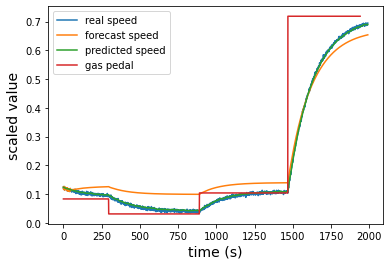

In [8]:
# Best window
best_window = best_params['window']

# Format data
Xtrain, ytrain, Xtest, ytest = format_data(window=best_window)

Yr = ytest
Yp = best_model.predict(Xtest)
Yf = ytest.copy()
for i in range(len(Yf)):
    if i < best_window:
        pass
    else:
        XQ = Xtest[i,:,0]
        XT = Yf[i-best_window:i]
        Xf = np.vstack((XQ,XT)).T
        Xf = np.reshape(Xf, (1, Xf.shape[0], Xf.shape[1])) 
        Yf[i] = best_model.predict(Xf)[0] 
        
plt.plot(Yr,label='real speed')
plt.plot(Yf,label='forecast speed')
plt.plot(Yp,label='predicted speed')
plt.plot(Xtest[best_window:,0,0],label='gas pedal')
plt.ylabel('scaled value',size=14)
plt.xlabel('time (s)',size=14)
plt.legend()

# Worst model results

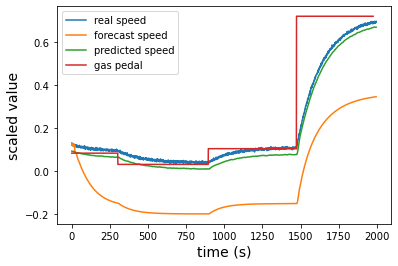

In [9]:
worst_window = worst_params['window']
Xtrain, ytrain, Xtest, ytest = format_data(window=worst_window)

Yr = ytest
Yp = worst_model.predict(Xtest)
Yf = ytest.copy()

for i in range(len(Yf)):
    if i < worst_window:
        pass
    else:
        XQ = Xtest[i,:,0]
        XT = Yf[i-worst_window:i]
        Xf = np.vstack((XQ,XT)).T
        Xf = np.reshape(Xf, (1, Xf.shape[0], Xf.shape[1])) 
        Yf[i] = worst_model.predict(Xf)[0] 
        
plt.plot(Yr,label='real speed')
plt.plot(Yf,label='forecast speed')
plt.plot(Yp,label='predicted speed')
plt.plot(Xtest[worst_window:,0,0],label='gas pedal')
plt.ylabel('scaled value',size=14)
plt.xlabel('time (s)',size=14)
plt.legend()